In [0]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import networkx as nx
import numpy as np
import sys
import math
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from google.colab import drive
import time
drive.mount('/content/drive')

class NaiveBayes:
  def __init__(self):
    self.pi = None
    self.theta = None
    
  def fit(self, X, y):
    C = int(y.max())
    D = X.shape[1]
    self.C = C
    self.D = D
    n = X.shape[0]
    self.pi = np.zeros((C,))
    self.theta = np.zeros((D,C))
    for c in range(1, C+1):
      n_c = 0
      for i in range(n):
        if y[i] == c:
          n_c = n_c + 1
      self.pi[c-1] = n_c/n
      for j in range(D):
        n_j_c = 0
        for i in range(n):
          if X[i, j] == 1 and y[i] == c:
            n_j_c = n_j_c + 1
        self.theta[j, c-1] = n_j_c/n_c
        
  def predict_vector(self, X):
    prob = np.zeros((self.C,))
    for c in range(1, self.C+1):
      theta = 1
      for j in range(self.D):
        theta = theta*self.theta[j,c-1]
      prob[c-1] = self.pi[c-1]*theta
    return np.argmax(prob, axis=0)+1
  
  def predict(self, X):
    pred = np.zeros((X.shape[0],))
    for i in range(X.shape[0]):
      pred[i] = self.predict_vector(X[i,:])
    return pred

class PCA:
    def __init__(self, k=None):
        self.k = k
    
    def fit(self, X):
        if self.k is None or self.k > X.shape[0]:
            self.k = X.shape[0]
        X_mean = X.sum(axis=0)/X.shape[0]
        self.X_mean = X_mean
        X = (X-X_mean)
        E = np.matmul(X.transpose(), X)/(X.shape[0]-1)
        eig_values, eig_vectors = np.linalg.eig(E)
        eig_vectors = eig_vectors[:, eig_values.argsort()[::-1]]
        eig_values.sort()
        eig_values = eig_values[::-1]
        self.eig_values = np.real(eig_values)
        self.eig_vectors = np.real(eig_vectors)
        self.pve_list = []
        eig_sum = np.sum(self.eig_values)
        pve_sum = 0
        for i in range(self.eig_values.shape[0]):
          pve_sum = pve_sum + self.eig_values[i]
          self.pve_list.append(pve_sum/eig_sum)
    
    def transform(self, X):
        X = X-self.X_mean
        Z = np.matmul(X, self.eig_vectors)[:,:self.k]
        return Z
      
class Initializer:
  def __init__(self):
    self.in_shape = None
    self.out_shape = None
  
  def get_weights(self, shape):
    if len(shape) == 2:
      self.in_shape = shape[0]
      self.out_shape = shape[1]
    else:
      self.in_shape = np.prod(shape[1:])
      self.out_shape = shape[0]

class GlorotUniform(Initializer):
  def __init__(self):
    super().__init__()
  
  def get_weights(self, shape):
    super().get_weights(shape)
    scale = np.sqrt(6.0 / (self.in_shape + self.out_shape))
    W = np.random.uniform(low=-scale, high=scale, size=shape)
    return W
  
class GlorotNormal(Initializer):
  def __init__(self):
    super().__init__()
    
  def get_weights(self, shape):
    super().get_weights(shape)
    scale = np.sqrt(2.0/(self.in_shape+self.out_shape))
    return np.random.normal(loc=0.0, scale=scale, size=shape)
    
  
class HeNormal(Initializer):
  def __init__(self):
    super().__init__()
  
  def get_weights(self, shape):
    super().get_weights(shape)
    scale = np.sqrt(2.0/self.in_shape)
    return np.random.normal(loc=0.0, scale=scale, size=shape)
  
class Layer:
    #EPSILON = sys.float_info.min
    EPSILON = 1e-8
    def __init__(self):
        self.d = {}
        self.out = None
        self.graph = None
        self.grad = None
    
    def add_backward(self, network):
        pass
    
    def forward(self):
        pass
    
    def backward(self):
        last = self.graph.last
        if len(list(self.graph.neighbors(self))) == 0:
            d = np.ones_like(self.out, dtype=np.float64)
        else:
            d = np.zeros_like(self.out, dtype=np.float64)
            for node in self.graph.neighbors(self):
                d = d + node.d[self]*last.d[node]
        last.d[self] = d
        if self.grad is None:
            self.grad = d
        else:
            self.grad = self.grad + d
    
    def size(self):
        return self.out.shape
    
class Variable(Layer):
    #Any dimension
    def __init__(self, size=(1,)):
        super().__init__()
        self.out = np.zeros(size, dtype=np.float64)
        network.node_labels[self] = 'Variable'
    
    def feed(self, x):
        if x.shape != self.out.shape:
            raise Exception('''Input to the variable
                            does not have
                            the right size''')
        self.out = x

class Constant(Layer):
    #Any dimension
    def __init__(self, const, size=(1,)):
        super().__init__()
        self.out = np.zeros(size, dtype=np.float64)+const
        network.node_labels[self] = 'Constant'
        
class Weight(Layer):
    #Any dimension
    def __init__(self, initial_value = np.zeros((1,), dtype=np.float64)):
        super().__init__()
        self.out = initial_value
        network.node_labels[self] = 'Weight'

class Operator(Layer):
    def __init__(self, *layers):
        super().__init__()
        self.layer_list = []
        for layer in layers:
            self.layer_list.append(layer)
        self.out = np.zeros_like(self.layer_list[0].out)
        
    def add_backward(self, network):
        for layer in self.layer_list:
            if not network.has_node(layer):
              network.add_node(layer)
              network.node_labels[self] = 'Operator'
            if not network.has_edge(layer, self):
              network.add_edge(layer, self)

class UnaryOperator(Layer):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer
        self.out = np.zeros(layer.size())
        
    def add_backward(self, network):
        if not network.has_node(self.layer):
          network.add_node(self.layer)
          network.node_labels[self] = 'UnaryOperator'
        if not network.has_edge(self.layer, self):
          network.add_edge(self.layer, self)
            
class Add(Operator):
    def __init__(self, *layers):
      super().__init__(*layers)
      self.ones_grad = np.ones_like(self.layer_list[0].out, dtype=np.float64)
      
    def forward(self):
        self.out = None
        for layer in self.layer_list:
            if self.out is None:
                self.out = layer.out
            else:
                self.out = self.out + layer.out
        
    def backward(self):
        super().backward()
        for i in range(len(self.layer_list)):
            self.d[self.layer_list[i]] = self.ones_grad[:]

class Multiply(Operator):    
    def forward(self):
        self.out = None
        for layer in self.layer_list:
            if self.out is None:
                self.out = layer.out
            else:
                self.out = self.out * layer.out
        
    def backward(self):
        super().backward()
        for layer in self.layer_list:
            self.d[layer] = self.out / (layer.out + Layer.EPSILON)

class ReduceSum(Layer):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer
        self.out = np.zeros((1,))
        self.ones_grad = np.ones_like(self.layer.out, dtype=np.float64)
    
    def add_backward(self, network):
        if not network.has_node(self.layer):
          network.add_node(self.layer)
          network.node_labels[self] = 'ReduceSum'
        if not network.has_edge(self.layer, self):
          network.add_edge(self.layer, self)
    
    def forward(self):
        self.out = np.sum(self.layer.out)
    
    def backward(self):
        super().backward()
        self.d[self.layer] = self.ones_grad[:]

class Reciprocal(UnaryOperator):
    def forward(self):
        self.out = np.power(self.layer.out, -1)
    
    def backward(self):
        super().backward()
        self.d[self.layer] = -np.power(self.layer.out*self.layer.out+Layer.EPSILON, -1)
        
class Exp(UnaryOperator):
    def forward(self):
        self.out = np.exp(np.clip( self.layer.out, -1000, 700 ))
    
    def backward(self):
        super().backward()
        self.d[self.layer] = np.exp(np.clip( self.layer.out, -1000, 700 ))
        
class Sigmoid(UnaryOperator):   
    def forward(self):
        self.out = 1.0/(1+np.exp(np.clip( -self.layer.out, -1000, 700 )))
        
    def backward(self):
        super().backward()
        self.d[self.layer] = self.out*(1-self.out)
        
class Identity(UnaryOperator):
    def __init__(self, layer):
      super().__init__(layer)
      self.ones_grad = np.ones_like(self.layer.out, dtype=np.float64)   
      
    def forward(self):
        self.out = self.layer.out
    
    def backward(self):
        super().backward()
        self.d[self.layer] = self.ones_grad[:]

class Log(UnaryOperator):
    def forward(self):
        self.out = np.log(self.layer.out+Layer.EPSILON)
    
    def backward(self):
        super().backward()
        self.d[self.layer] = 1.0/(self.layer.out+Layer.EPSILON)

class ReLU(UnaryOperator):
    def forward(self):
        self.out = np.maximum(self.layer.out, 0)
    
    def backward(self):
        super().backward()
        self.d[self.layer] = (self.out>0)*1.0

class Ensemble(Layer):
    def __init__(self, layer_list):
        super().__init__()
        self.layer_list = layer_list
        size = self.layer_list[0].size()
        size = (len(self.layer_list),) + size
        self.out = np.zeros(size, dtype=np.float64)
        self.graph = self.layer_list[0].graph
    
    def forward(self):
      for i in range(len(self.layer_list)):
        self.out[i] = self.layer_list[i].out
        
    def backward(self):
        super().backward()
        last = self.graph.last
        for i in range(len(self.layer_list)):
          self.d[self.layer_list[i]] = last.d[self][i]
        last.d[self] = 1
        
    def add_backward(self, network):
        for layer in self.layer_list:
            if not network.has_node(layer):
              network.add_node(layer)
              network.node_labels[self] = 'Ensemble'
            if not network.has_edge(layer, self):
              network.add_edge(layer, self)
            
class Max(Layer):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer
        self.out = np.zeros((layer.out.shape[-1],), dtype=np.float64)
        self.zeros_grad = np.zeros_like(self.layer.out)
    
    def add_backward(self, network):
        if not network.has_node(self.layer):
          network.add_node(self.layer)
          network.node_labels[self] = 'Max'
        if not network.has_edge(self.layer, self):
          network.add_edge(self.layer, self)
    
    def forward(self):
        self.out = np.max(self.layer.out, axis=(0,1))
    
    def backward(self):
        super().backward()
        grad = np.zeros_like(self.layer.out, dtype=np.float64)
        for i in range(self.layer.out.shape[-1]):
            grad_ch = grad[:,:,i]
            grad_ravel = grad_ch.ravel()
            grad_ravel[grad_ch.argmax()] = 1
            grad_ch = grad_ravel.reshape(grad_ch.shape)
            grad[:,:,i] = grad_ch[:]
        self.d[self.layer] = grad
        
class Flatten(UnaryOperator):
    def __init__(self, layer):
        super().__init__(layer)
        self.out = self.layer.out.ravel()
    
    def forward(self):
        self.out = self.layer.out.ravel()
        
    def backward(self):
        super().backward()
        last = self.graph.last
        self.d[self.layer] = last.d[self].reshape(self.layer.out.shape)
        last.d[self] = 1
        
class Reshape(UnaryOperator):
    def __init__(self, layer, shape):
        super().__init__(layer)
        self.out = self.layer.out.reshape(shape)
        self.shape = shape
    
    def forward(self):
        self.out = self.layer.out.reshape(self.shape)
        
    def backward(self):
        super().backward()
        last = self.graph.last
        self.d[self.layer] = last.d[self].reshape(self.layer.out.shape)
        last.d[self] = 1

class Cut2D(UnaryOperator):
    def __init__(self, layer, location=(0,0), size=(3,3)):
        super().__init__(layer)
        self.location = location
        self.filter_size = size + (layer.size()[-1],)
        self.out = np.zeros(self.filter_size)
        self.zeros_grad = np.zeros(self.layer.size(), dtype=np.float64)
    
    def forward(self):
        self.out = self.layer.out[self.location[0]:self.location[0]+self.filter_size[0],
                                  self.location[1]:self.location[1]+self.filter_size[1]]
        
    def backward(self):
        super().backward()
        last = self.graph.last
        grad = self.zeros_grad[:]
        grad[self.location[0]:self.location[0]+self.filter_size[0],
             self.location[1]:self.location[1]+self.filter_size[1],:] = last.d[self]
        self.d[self.layer] = grad
        last.d[self] = 1
        
class Conv2DVector(Ensemble):
    def __init__(self, layer, filter_layer, bias, filter_size=(3,3), stride=1, location=0):
        layer_list = []
        for i in range(int( (layer.size()[1]-filter_size[1])/stride + 1)):
            cut_layer = Cut2D(layer, location=(location,i*stride), size=filter_size)
            reduce_sum = Add(bias, ReduceSum(Multiply(cut_layer,filter_layer)))
            layer_list.append(reduce_sum)
        super().__init__(layer_list)
        
class MaxPool2DVector(Ensemble):
    def __init__(self, layer, filter_size=(2,2),stride=2, location=0):
        layer_list = []
        for i in range(int( (layer.size()[1]-filter_size[1])/stride + 1)):
            layer_list.append(Max(Cut2D(layer, location=(location,i*stride), size=filter_size)))
        super().__init__(layer_list)

class Filter(Ensemble):
    def __init__(self, layer, filter_size=(3,3), stride=1, initializer=GlorotNormal()):
        layer_list = []
        W = initializer.get_weights((filter_size[0], filter_size[1], layer.size()[-1]))
        filter_layer = Weight(initial_value=W)
        bias = Weight(initial_value=np.zeros((1,)))
        for i in range(int( (layer.size()[0]-filter_size[0])/stride + 1)):
          conv2dvec = Conv2DVector(layer,  filter_layer, bias, filter_size=filter_size, stride=stride, location=i*stride)
          layer_list.append(conv2dvec)
        super().__init__(layer_list)
        
class MaxPool2D(Ensemble):
    def __init__(self, layer, filter_size=(2,2), stride=2):
        layer_list = []
        for i in range(int( (layer.size()[0]-filter_size[0])/stride + 1)):
            pool_vector = MaxPool2DVector(layer, filter_size=filter_size, stride=stride, location=i*stride )
            layer_list.append(pool_vector)
        super().__init__(layer_list)

class Conv2D(Layer):
    def __init__(self, layer, out_channel, filter_size=(3,3), stride=1, initializer=GlorotUniform()):
        super().__init__()
        layer_list = []
        for i in range(out_channel):
            filt = Filter(layer, filter_size=filter_size, stride=stride, initializer=initializer)
            filt = Reshape(filt, filt.size()[:-1])
            layer_list.append(filt)
        self.layer_list = layer_list
        size = self.layer_list[0].size() + (out_channel,)
        self.out = np.zeros(size, dtype=np.float64)
    
    def forward(self):
        for i in range(len(self.layer_list)):
            self.out[:,:,i] = self.layer_list[i].out[:,:]
        
    def backward(self):
        super().backward()
        last = self.graph.last
        for i in range(len(self.layer_list)):
            self.d[self.layer_list[i]] = last.d[self][:,:,i]
        last.d[self] = 1
        
    def add_backward(self, network):
        for layer in self.layer_list:
            if not network.has_node(layer):
              network.add_node(layer)
              network.node_labels[self] = 'Conv2D'
            if not network.has_edge(layer, self):
              network.add_edge(layer, self)

class MatMul(Ensemble):
    def __init__(self, W, layer):
        layer_list = []
        for i in range(W.shape[0]):
            layer_list.append(
                    ReduceSum(Multiply(Weight(initial_value=W[i,:]),
                                       layer)))
        super().__init__(layer_list)
        
class Dense(Ensemble):
    def __init__(self, layer, n, initializer=GlorotNormal()):
        W = initializer.get_weights((n, layer.size()[0]))
        bias = Weight(initial_value=np.zeros((n,1)))
        layer_list = []
        matmul = MatMul(W, layer)
        layer_list.append(Add(matmul,bias))
        super().__init__(layer_list)
        
class RepeatingVector(Ensemble):
    def __init__(self, layer, n):
        layer_list = []
        for i in range(n):
            layer_list.append(layer)
        super().__init__(layer_list)

class CrossEntropyLoss(Ensemble):
    def __init__(self, prediction, label):
        layer_list = []
        out = Log(prediction)
        out = Multiply(out, label)
        out = ReduceSum(out)
        out = Multiply(out, Constant(-1))
        layer_list.append(out)
        super().__init__(layer_list)

        
class L2Norm(Ensemble):
  def __init__(self, params):
    layer_list = []
    param_list = []
    for param in params:
      param_list.append(ReduceSum(Multiply(param, Identity(param))))
    layer_list.append(Add(*param_list))
    super().__init__(layer_list)

class SubtractMax(Layer):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer
        self.out = np.zeros(layer.size(), dtype=np.float64)
    
    def add_backward(self, network):
        if not network.has_node(self.layer):
          network.add_node(self.layer)
        if not network.has_edge(self.layer, self):
          network.add_edge(self.layer, self)
    
    def forward(self):
        self.out = self.layer.out-np.max(self.layer.out)
    
    def backward(self):
        super().backward()
        self.d[self.layer] = np.ones_like(self.layer.out)

class Softmax(Ensemble):
    def __init__(self, layer):
        layer_list = []
        layer_sub = SubtractMax(layer)
        exp = Exp(layer_sub)
        inv = Reciprocal(ReduceSum(exp))
        inv = RepeatingVector(inv, exp.size()[0])
        layer_list.append(Multiply(exp, inv))
        super().__init__(layer_list)

        
class Optimizer:
    def __init__(self, network, reset = False):
        self.params = []
        self.network = network
        self.optim_dict = {}
        self.optim_dict['loss_list'] = []
        self.loss_value = 0
        for node in nx.topological_sort(network):
            if isinstance(node,Weight):
                self.params.append(node)
        if reset == False:
          self.load_history()
        
    def step(self):
        '''
        An optimizer can override this def to
        implement different update rules.
        It can store grad matrices for RMSProp
        and can delete by this def.
        '''
        pass
        
    def epoch(self):
      self.optim_dict['loss_list'].append(self.loss_value)
      self.loss_value = 0
      self.save_history()
      
    def batch(self):
      self.loss_value = self.loss_value + network.last.out[0]
    
    def zero_grad(self):
        for node in nx.topological_sort(self.network):
            node.grad = None
            node.d = {}
            
    def save_history(self):
      path = os.path.join(Network.path, self.network.name + '_optim.npy')
      np.save(path, self.optim_dict, allow_pickle=True)
      self.network.save_model()
      
    def load_history(self):
      path = os.path.join(Network.path, self.network.name + '_optim.npy')
      if os.path.exists(path):
        self.optim_dict = np.load(path, allow_pickle=True).item()
        print('Optimizer loaded from memory.')
        return True
      return False

class SGD(Optimizer):
    def __init__(self, network, learning_rate = 0.1, momentum=0.9, weight_decay=0.01, reset=False):
        super().__init__(network, reset=reset)
        self.learning_rate = learning_rate 
        self.momentum = momentum
        self.N = 0
        self.weight_decay = weight_decay
        for param in self.params:
          param.m = 0
        
    def step(self):
        for param in self.params:
            param.m = self.momentum*param.m + (1-self.momentum)*param.grad
            param.out = (1-(2*self.learning_rate*self.weight_decay)/self.N)*param.out - self.learning_rate*param.m
            
    def batch(self):
      super().batch()
      self.N = self.N + 1
    
    def epoch(self):
      super().epoch()
      self.N = 0
      
class Adadelta(Optimizer):
  def __init__(self, network, decay_rate=0.9, epsilon = 1e-6, reset=False):
    super().__init__(network, reset=reset)
    self.decay_rate = decay_rate
    self.epsilon = epsilon
    for param in self.params:
      param.cum_grad = 0
      param.cum_update = 0
    
  def step(self):
    for param in self.params:
      param.cum_grad = self.decay_rate*param.cum_grad + ((1-self.decay_rate)*param.grad)*param.grad
      rms_grad = np.sqrt(param.cum_grad+self.epsilon)
      rms_update = np.sqrt(param.cum_update+self.epsilon)
      update = -(rms_update/rms_grad)*param.grad
      param.out = param.out + update
      param.cum_update = self.decay_rate*param.cum_update + ((1-self.decay_rate)*update)*update
            
class Adam(Optimizer):
  def __init__(self, network, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon = 1.0,reset=False):
    super().__init__(network, reset=reset)
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.optim_dict['is_first_epoch'] = True
    for param in self.params:
      param.m = 0
      param.v = 0
    
  def step(self):
    for param in self.params:
      if param.out.shape != param.grad.shape:
        print("Error with grad")
      """if self.optim_dict['is_first_epoch']:
        param.m = param.grad
        param.v = param.grad*param.grad
        self.optim_dict['is_first_epoch'] = False
      else:"""
      param.m = self.beta1*param.m + (1-self.beta1)*param.grad
      param.v = self.beta2*param.v + ((1-self.beta2)*param.grad)*param.grad
      param.out = param.out - self.learning_rate*param.m/(np.sqrt(param.v)+self.epsilon)
  
  def save_history(self):
    i = 0
    for param in self.params:
      self.optim_dict[str(i)+'_adam'] = (param.m, param.v)
      i = i + 1
    super().save_history()
    
  def load_history(self):
    if super().load_history():
      i = 0
      for param in self.params:
        param.m, param.v = self.optim_dict[str(i)+'_adam']
        i = i + 1
    
class Network(nx.DiGraph):
    path = '/content/drive/My Drive/SL_Project/model'
    def __init__(self, name='network'):
        super().__init__()
        self.last = None
        self.node_labels = {}
        self.name = name
        self.model_dict = {}
        self.model_dict['smallest_valid_error'] = -1
        self.model_dict['valid_error_list'] = []
        
    def get_params(self):
      params = []
      for node in nx.topological_sort(network):
            if isinstance(node,Weight):
                params.append(node)
      return params
    
    def forward(self):
        for node in nx.topological_sort(self):
            node.forward()
        
    def backward(self):
        topological_sorted = list(nx.topological_sort(self))
        self.last = topological_sorted[-1]
        for node in reversed(topological_sorted):
            node.backward()
    
    def add_node(self, node):
        super().add_node(node)
        node.graph = self
        node.add_backward(self)
        
    def save_model(self):
        i = 0
        for node in nx.topological_sort(self):
            if isinstance(node, Weight):
                self.model_dict[str(i)] = node.out
                i = i + 1
        np.save(os.path.join(Network.path, self.name+'.npy'), self.model_dict, allow_pickle=True)
        
    def save_validation(self):
        i = 0
        for node in nx.topological_sort(self):
            if isinstance(node, Weight):
                self.model_dict[str(i)+'_valid'] = node.out
                i = i + 1
        
    def load_model(self):
        self.model_dict = np.load(os.path.join(Network.path, self.name+'.npy'), allow_pickle=True).item()
        i = 0
        for node in nx.topological_sort(self):
            if isinstance(node, Weight):
                node.out = self.model_dict[str(i)]
                i = i + 1
        print('Model loaded from memory.')
        
    def load_validation(self):
        self.load_model()
        i = 0
        for node in nx.topological_sort(self):
            if isinstance(node, Weight):
                node.out = self.model_dict[str(i)+'_valid']
                i = i + 1
        print('Smallest validation model loaded from memory.')
        
    def predict(self, x, y, x_test):
      y_pred = np.empty((x_test.shape[0],)+y.size())
      for i in range(x_test.shape[0]):
        x_feed = x_test[i,:].reshape(x.size())
        x.feed(x_feed)
        self.forward()
        y_pred[i,:] = y.out
      return y_pred
        
    def train(self, x, y, x_train, y_train, optimizer,
              x_validation = None, y_validation = None,
              num_of_epoch=5, batch_size=None, save=True):
      for epoch in range(1,num_of_epoch+1):
          i = 0
          ETA = 0
          total_time = 0
          if batch_size is None:
            batch_size = x_train.shape[0]
          while i < x_train.shape[0]:
              x_batch = x_train[i:i+batch_size, :]
              y_batch = y_train[i:i+batch_size, :]
              i = i + batch_size
              optimizer.zero_grad()
              sys.stdout.flush()
              sys.stdout.write('\r')
              percent = int(100*(i-batch_size)/x_train.shape[0])
              sys.stdout.write("EPOCH %d/%d [%-20s] %d%% loss: %f ETA: %d s" % (epoch, num_of_epoch,int(percent/5)*'=', percent, optimizer.loss_value, ETA))
              start = time.time()
              for j in range(x_batch.shape[0]):
                  x_feed = x_batch[j,:].reshape(x.size())
                  y_feed = y_batch[j,:].reshape(y.size())
                  x.feed(x_feed)
                  y.feed(y_feed)
                  self.forward()
                  self.backward()
                  optimizer.batch()
              end = time.time()
              total_time = total_time + int(end-start)
              sys.stdout.flush()
              percent = int(100*(i-batch_size+x_batch.shape[0])/x_train.shape[0])
              if percent == 0:
                ETA = 0
              else:
                ETA = int(100*total_time/percent)-total_time
              sys.stdout.write('\r')
              sys.stdout.write("EPOCH %d/%d [%-20s] %d%% loss: %f ETA: %d s" % (epoch, num_of_epoch,int(percent/5)*'=', percent, optimizer.loss_value, ETA))
              optimizer.step()
          optimizer.epoch()
          if x_validation is not None and y_validation is not None:
            valid_loss = 0
            for j in range(x_validation.shape[0]):
              x_feed = x_validation[j,:].reshape(x.size())
              y_feed = y_validation[j,:].reshape(y.size())
              x.feed(x_feed)
              y.feed(y_feed)
              self.forward()
              valid_loss = valid_loss + self.last.out[0]
            sys.stdout.write(' validation loss: %f' % (valid_loss))
            self.model_dict['valid_error_list'].append(valid_loss)
            if self.model_dict['smallest_valid_error'] < 0 or valid_loss<self.model_dict['smallest_valid_error']:
              self.model_dict['smallest_valid_error'] = valid_loss
              self.save_validation()
          sys.stdout.write('\n')
      if save:
        optimizer.save_history()
    
"""
Validation loss list -> network.model_dict['valid_error_list']
Training loss list -> optimizer.optim_dict['loss_list']
"""


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


"\nValidation loss list -> network.model_dict['valid_error_list']\nTraining loss list -> optimizer.optim_dict['loss_list']\n"

### Adult Data

In [0]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')
data = data.iloc[:,:].values

label_encoder = LabelEncoder()
data[:,1] = label_encoder.fit_transform(data[:,1])
data[:,3] = label_encoder.fit_transform(data[:,3])
data[:,5] = label_encoder.fit_transform(data[:,5])
data[:,6] = label_encoder.fit_transform(data[:,6])
data[:,7] = label_encoder.fit_transform(data[:,7])
data[:,8] = label_encoder.fit_transform(data[:,8])
data[:,9] = label_encoder.fit_transform(data[:,9])
data[:,13] = label_encoder.fit_transform(data[:,13])
data[:,14] = label_encoder.fit_transform(data[:,14])
x_data = data[:,:14]
y_data = data[:,14:]

one_hot_encoder = OneHotEncoder(categorical_features=[0])
y_data = one_hot_encoder.fit_transform(y_data).toarray()

one_hot_encoder = OneHotEncoder(categorical_features=[1,3,5,6,7,8,9,13])
x_data = one_hot_encoder.fit_transform(x_data).toarray()

for i in range(x_data.shape[1]):
  x_data[:,i] = (x_data[:,i] - x_data[:,i].min())/(x_data[:,i].max()-x_data[:,i].min())
x_data = (x_data>0.5)*1

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, shuffle=True)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.20, shuffle=True)

standard_scaler = StandardScaler()
#x_train = standard_scaler.fit_transform(x_train)
#x_validation = standard_scaler.transform(x_validation)
#x_test = standard_scaler.transform(x_test)

print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)
print(x_test.shape, y_test.shape)

(20838, 108) (20838, 2)
(5210, 108) (5210, 2)
(6512, 108) (6512, 2)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data w

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

0.9998216272930435


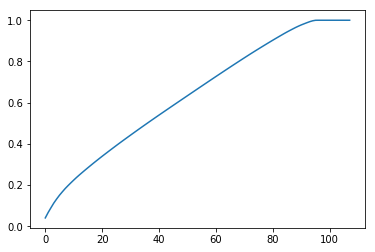

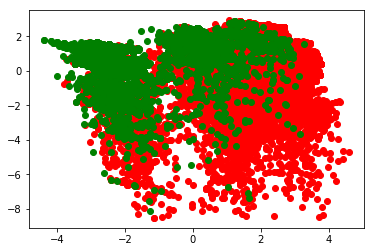

In [0]:
scaler = StandardScaler()
x_train_pca = x_train.reshape((x_train.shape[0], 108))
x_train_pca = scaler.fit_transform(x_train_pca)
x_validation_pca = x_validation.reshape((x_validation.shape[0], 108))
x_validation_pca = scaler.fit_transform(x_validation_pca)
x_test_pca = x_test.reshape((x_test.shape[0], 108))
x_test_pca = scaler.fit_transform(x_test_pca)
pca = PCA(k=95)
pca.fit(x_train_pca)
x_train_pca = pca.transform(x_train_pca)
x_validation_pca = pca.transform(x_validation_pca)
x_test_pca = pca.transform(x_test_pca)
print(pca.pve_list[95])
plt.plot(pca.pve_list)
plt.show()

def plot_pca(x_train_pca, y_train_):
  y_train_ = np.argmax(y_train_, axis=1)
  x_train_zero = x_train_pca[y_train_==0, :2]
  x_train_one = x_train_pca[y_train_==1, :2]
  plt.plot(x_train_zero[:,0], x_train_zero[:,1], 'ro')
  plt.plot(x_train_one[:,0], x_train_one[:,1], 'go')
  plt.show()

plot_pca(x_train_pca, y_train[:,0:2])

In [0]:
for i in range(x_test_pca.shape[1]):
  x_test_pca[:,i] = (x_test_pca[:,i] - x_test_pca[:,i].min())/(x_test_pca[:,i].max()-x_test_pca[:,i].min())
x_test_pca = (x_test_pca>0.5)*1

for i in range(x_train_pca.shape[1]):
  x_train_pca[:,i] = (x_train_pca[:,i] - x_train_pca[:,i].min())/(x_train_pca[:,i].max()-x_train_pca[:,i].min())
x_train_pca = (x_train_pca>0.5)*1

for i in range(x_validation_pca.shape[1]):
  x_validation_pca[:,i] = (x_validation_pca[:,i] - x_validation_pca[:,i].min())/(x_validation_pca[:,i].max()-x_validation_pca[:,i].min())
x_validation_pca = (x_validation_pca>0.5)*1


In [0]:
network = Network(name='fcnn')

x = Variable(size=(108,))
y = Variable(size=(2,1))

dense1 = Dense(x, 32)
dense1 = ReLU(Reshape(dense1, dense1.size()[1]))

dense2 = Dense(dense1, 128)
dense2 = ReLU(Reshape(dense2, dense2.size()[1]))

dense3 = Dense(dense2, 32)
dense3 = ReLU(Reshape(dense3, dense3.size()[1]))
dense3 = Add(dense1, dense3)

dense4 = Dense(dense3, 128)
dense4 = ReLU(Reshape(dense4, dense4.size()[1]))

dense5 = Dense(dense4, 32)
dense5 = ReLU(Reshape(dense5, dense5.size()[1]))
dense5 = Add(dense3, dense5)

dense6 = Dense(dense5, 2)
dense6 = Reshape(dense6, dense6.size()[1:])
softmax = Softmax(dense6)
softmax = Reshape(softmax, softmax.size()[1:])
loss = CrossEntropyLoss(softmax, y)
loss = Reshape(loss, (1,))
network.add_node(loss)

network.load_model()
optimizer = Adadelta(network, reset=True)
optimizer.load_history()

Model loaded from memory.
Optimizer loaded from memory.


True

In [0]:
#validation accuracy before training
y_pred = network.predict(x, softmax, x_validation)
y_ = y_validation.argmax(axis=1)
y_pred_ = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))
y_pred_ = y_pred_.argmax(axis=1)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred_, y_))

0.2418426103646833


In [0]:
network.train(x, y,
              x_train,
              y_train,
              optimizer,
              num_of_epoch=3,
              x_validation = x_validation,
              y_validation = y_validation,
              batch_size=None)

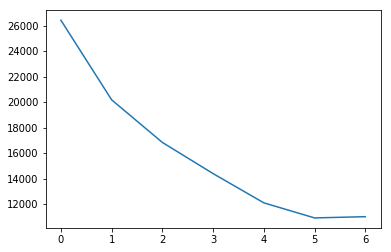

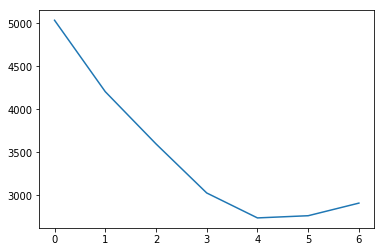

In [0]:
plt.plot(optimizer.optim_dict['loss_list'])
plt.show()
plt.plot(network.model_dict['valid_error_list'])
plt.show()

In [0]:
#smallest validation error accuracy after training

network.load_validation()
y_pred = network.predict(x, softmax, x_validation)
y_ = y_validation.argmax(axis=1)
y_pred_ = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))
y_pred_ = y_pred_.argmax(axis=1)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred_, y_))

Model loaded from memory.
Smallest validation model loaded from memory.
0.7585412667946257


In [0]:
#test accuracy on smallest validation error

network.load_validation()
y_pred = network.predict(x, softmax, x_test)
y_ = y_test.argmax(axis=1)
y_pred_ = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))
y_pred_ = y_pred_.argmax(axis=1)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred_, y_))

Model loaded from memory.
Smallest validation model loaded from memory.
0.7667383292383292


In [0]:
#Naive bayes with PCA
naive_bayes = NaiveBayes()
y_train_pca = y_train.argmax(axis=1)+1
y_test_pca = y_test.argmax(axis=1)+1
naive_bayes.fit(x_train_pca, y_train_pca)
y_pred = naive_bayes.predict(x_test_pca)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred, y_test_pca))

0.7570638820638821


In [0]:
#Naive bayes without PCA
naive_bayes = NaiveBayes()
y_train_nb = y_train.argmax(axis=1)+1
y_test_nb = y_test.argmax(axis=1)+1
naive_bayes.fit(x_train, y_train_nb)
y_pred = naive_bayes.predict(x_test)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred, y_test_nb))

0.7625921375921376


### Emotion

In [0]:
"""
y is an 8 dimensional vector.
Representation of 8 dimensions are given as follows.

1      0           0         0
0 up   1  straight 0 left    0 right
0      0           1         0
0      0           0         1

1      0           0         0
0      1           0         0
0      0           1         0
0 sad  0  neutral  0  happy  1 angry 

1      0
0 open 1 sunglasses
"""

x_data = np.load('/content/drive/My Drive/SL_Project/x_data.npy')
y_data = np.load('/content/drive/My Drive/SL_Project/y_data.npy')
x_data_flip = x_data[:,:,::-1]
y_data_flip = y_data.copy()
for i in range(y_data.shape[0]):
  if y_data[i,2] == 1:
    y_data_flip[i,2] = 0
    y_data_flip[i,3] = 1
  elif y_data[i,3] == 1:
    y_data_flip[i,2] = 1
    y_data_flip[i,3] = 0

x_data = np.concatenate((x_data, x_data_flip), axis=0)
y_data = np.concatenate((y_data, y_data_flip), axis=0)

x_data_r = np.roll(x_data, 8, axis=2)
x_data_l = np.roll(x_data, -8, axis=2)
x_data_u = np.roll(x_data, 4, axis=1)
x_data_d = np.roll(x_data, -4, axis=1)
x_data = np.concatenate((x_data, x_data_r, x_data_l, x_data_u, x_data_d), axis=0)
y_data = np.concatenate((y_data, y_data, y_data, y_data, y_data), axis=0)

#normalize the data
"""
for i in range(x_data.shape[0]):
  x_data[i,:] = (x_data[i,:] - x_data[i,:].min())/(x_data[i,:].max()-x_data[i,:].min())"""
  
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, shuffle=True)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.20, shuffle=True)
x_train_flat = x_train.reshape((x_train.shape[0], 60*64))
x_validation_flat = x_validation.reshape((x_validation.shape[0], 60*64))
x_test_flat = x_test.reshape((x_test.shape[0], 60*64))

scaler = StandardScaler()

x_train_flat = scaler.fit_transform(x_train_flat)
x_validation_flat = scaler.fit_transform(x_validation_flat)
x_test_flat = scaler.fit_transform(x_test_flat)

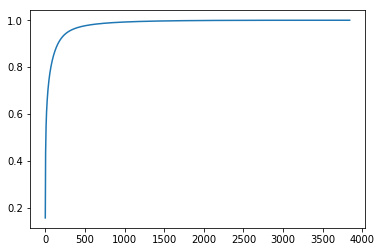

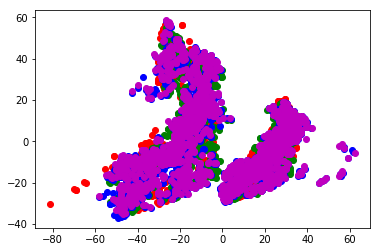

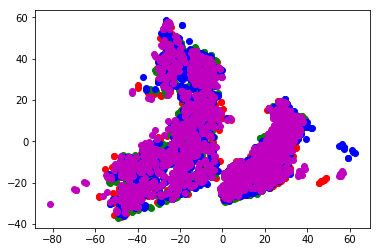

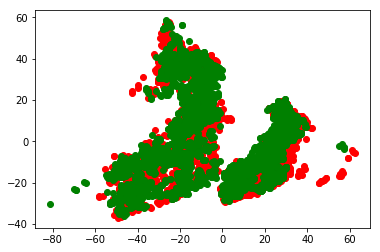

In [0]:
x_train_pca = x_train_flat[:]
x_validation_pca = x_validation_flat[:]
x_test_pca = x_test_flat[:]
pca = PCA(k=500)
pca.fit(x_train_pca)
x_train_pca = pca.transform(x_train_pca)
x_validation_pca = pca.transform(x_validation_pca)
x_test_pca = pca.transform(x_test_pca)

plt.plot(pca.pve_list)
plt.show()

def plot_pca(x_train_pca, y_train_):
  y_train_ = np.argmax(y_train_, axis=1)
  x_train_zero = x_train_pca[y_train_==0, :2]
  x_train_one = x_train_pca[y_train_==1, :2]
  x_train_two = x_train_pca[y_train_==2, :2]
  x_train_three = x_train_pca[y_train_==3, :2]
  plt.plot(x_train_zero[:,0], x_train_zero[:,1], 'ro')
  plt.plot(x_train_one[:,0], x_train_one[:,1], 'go')
  plt.plot(x_train_two[:,0], x_train_two[:,1], 'bo')
  plt.plot(x_train_three[:,0], x_train_three[:,1], 'mo')
  plt.show()

plot_pca(x_train_pca, y_train[:,0:4])
plot_pca(x_train_pca, y_train[:,4:8])
plot_pca(x_train_pca, y_train[:,8:10])

In [0]:
for i in range(x_test_pca.shape[1]):
  x_test_pca[:,i] = (x_test_pca[:,i] - x_test_pca[:,i].min())/(x_test_pca[:,i].max()-x_test_pca[:,i].min())
x_test_pca = (x_test_pca>0.5)*1

for i in range(x_train_pca.shape[1]):
  x_train_pca[:,i] = (x_train_pca[:,i] - x_train_pca[:,i].min())/(x_train_pca[:,i].max()-x_train_pca[:,i].min())
x_train_pca = (x_train_pca>0.5)*1

for i in range(x_validation_pca.shape[1]):
  x_validation_pca[:,i] = (x_validation_pca[:,i] - x_validation_pca[:,i].min())/(x_validation_pca[:,i].max()-x_validation_pca[:,i].min())
x_validation_pca = (x_validation_pca>0.5)*1


In [0]:
#Naive bayes with PCA
naive_bayes = NaiveBayes()
y_train_pca = y_train.argmax(axis=1)+1
y_test_pca = y_test.argmax(axis=1)+1
naive_bayes.fit(x_train_pca, y_train_pca)
y_pred = naive_bayes.predict(x_test_pca)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred, y_test_pca))

0.25801282051282054


In [0]:
#Naive bayes without PCA
naive_bayes = NaiveBayes()
y_train_nb = y_train.argmax(axis=1)+1
y_test_nb = y_test.argmax(axis=1)+1
naive_bayes.fit(x_train_flat, y_train_nb)
y_pred = naive_bayes.predict(x_test_flat)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred, y_test_nb))

0.24959935897435898


In [0]:
x_train = (x_train-x_train.mean())/x_train.std()
x_test = (x_test-x_test.mean())/x_test.std()
x_validation = (x_validation-x_validation.mean())/x_validation.std()

y_train_sub = y_train[:,4:8]
y_validation_sub = y_validation[:,4:8]
y_test_sub = y_test[:,4:8]

In [0]:
print(x_train.shape)

(7987, 60, 64)


In [0]:
network = Network(name='conv_net')
x = Variable(size=(60,64,1))
y = Variable(size=(4,1))
conv1 = ReLU(MaxPool2D(Conv2D(x, 16, filter_size=(5,5), stride=2)))
conv2 = ReLU(MaxPool2D(Conv2D(conv1, 32, filter_size=(5,5), stride=2)))
flatten = Flatten(conv2)
dense1 = Dense(flatten, 16)
dense1 = ReLU(Reshape(dense1, dense1.size()[1]))
dense2 = Dense(dense1, 4)
dense2 = Reshape(dense2, dense2.size()[1:])
softmax = Softmax(dense2)
softmax = Reshape(softmax, softmax.size()[1:])
loss = CrossEntropyLoss(softmax, y)
loss = Reshape(loss, (1,))
network.add_node(loss)
#network.load_model()
optimizer = Adadelta(network, reset=True)

In [0]:
#validation accuracy before training
y_pred = network.predict(x, softmax, x_validation)
y_ = y_validation_sub.argmax(axis=1)
y_pred_ = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))
y_pred_ = y_pred_.argmax(axis=1)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred_, y_))

0.2513770655983976


In [0]:
network.train(x, y,
              x_train,
              y_train_sub,
              optimizer,
              x_validation = x_validation,
              y_validation = y_validation_sub,
              num_of_epoch=3,
              batch_size = None)

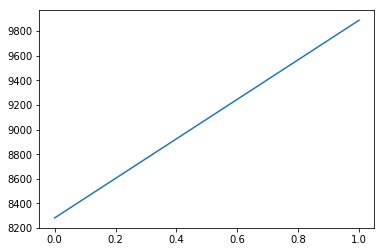

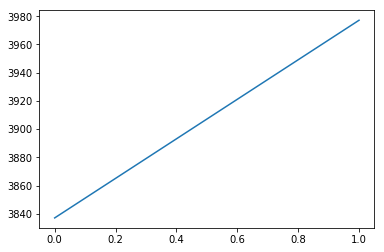

In [0]:
plt.plot(network.model_dict['valid_error_list'])
plt.show()
plt.plot(optimizer.optim_dict['loss_list'])
plt.show()

In [0]:
#smallest validation error accuracy after training

network.load_validation()
y_pred = network.predict(x, softmax, x_validation)
y_ = y_validation_sub.argmax(axis=1)
y_pred_ = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))
y_pred_ = y_pred_.argmax(axis=1)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred_, y_))

Model loaded from memory.
Smallest validation model loaded from memory.
0.24937406109163746


In [0]:
#test accuracy on smallest validation error

network.load_validation()
y_pred = network.predict(x, softmax, x_test)
y_ = y_test_sub.argmax(axis=1)
y_pred_ = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))
y_pred_ = y_pred_.argmax(axis=1)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred_, y_))

Model loaded from memory.
Smallest validation model loaded from memory.
0.2467948717948718
